### Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### Instrucciones del proyecto

1. Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
2. Analiza los datos.
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

### Descripción de datos

Los datos se almacenan en el archivo /data/taxi.csv.

El número de pedidos está en la columna num_orders.

### Preparacion

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Null data:  num_orders    0
dtype: int64

Data Resampling:

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, Length: 4416, dtype: int64

Datetime visualization



<Axes: xlabel='datetime'>

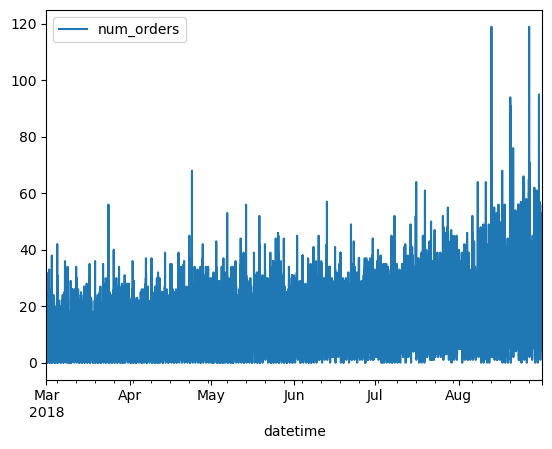

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

taxi_df = pd.read_csv('data/taxi.csv', parse_dates=[0], index_col=[0])

print(taxi_df.info())
display(taxi_df.head())
print(taxi_df.describe())
print('\nNull data: ', taxi_df.isna().sum())

# Data resampling
print('\nData Resampling:\n')
taxi_hourly = taxi_df['num_orders'].resample('1h').sum()
print(taxi_hourly)
# Data visualization
print()
print('Datetime visualization\n')
taxi_df.plot()


### Analisis

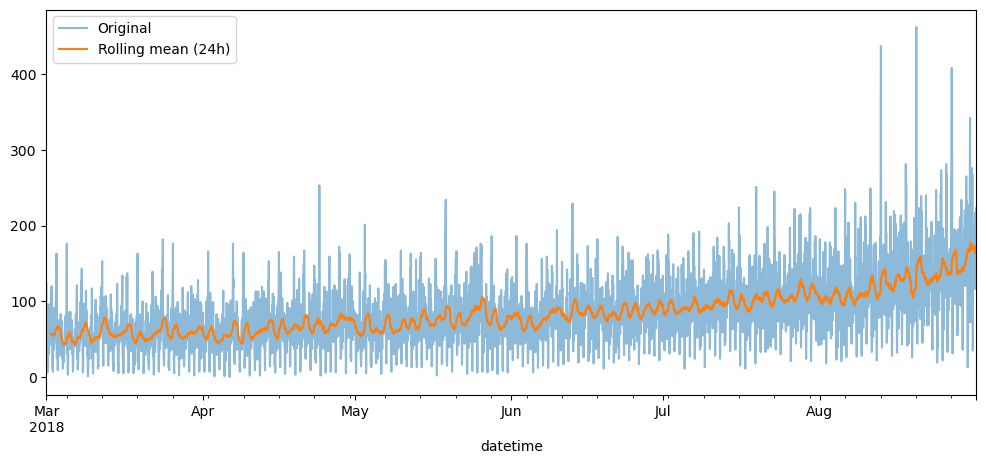

0


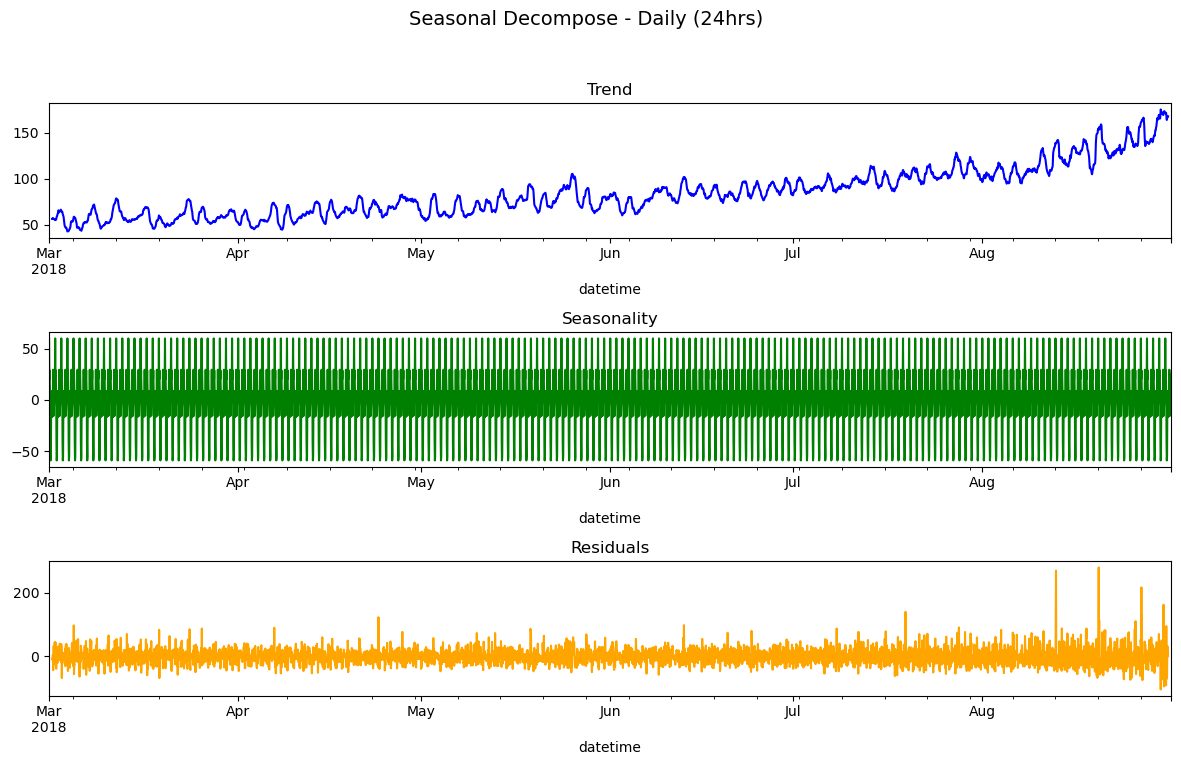

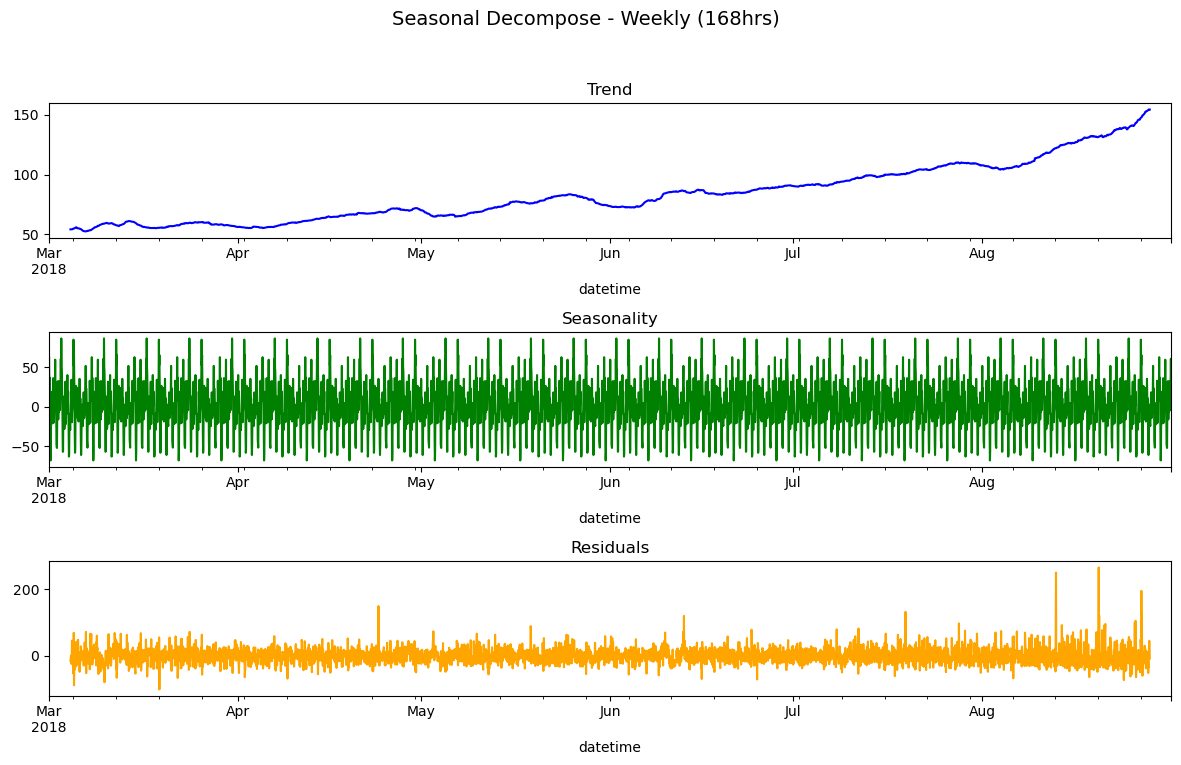

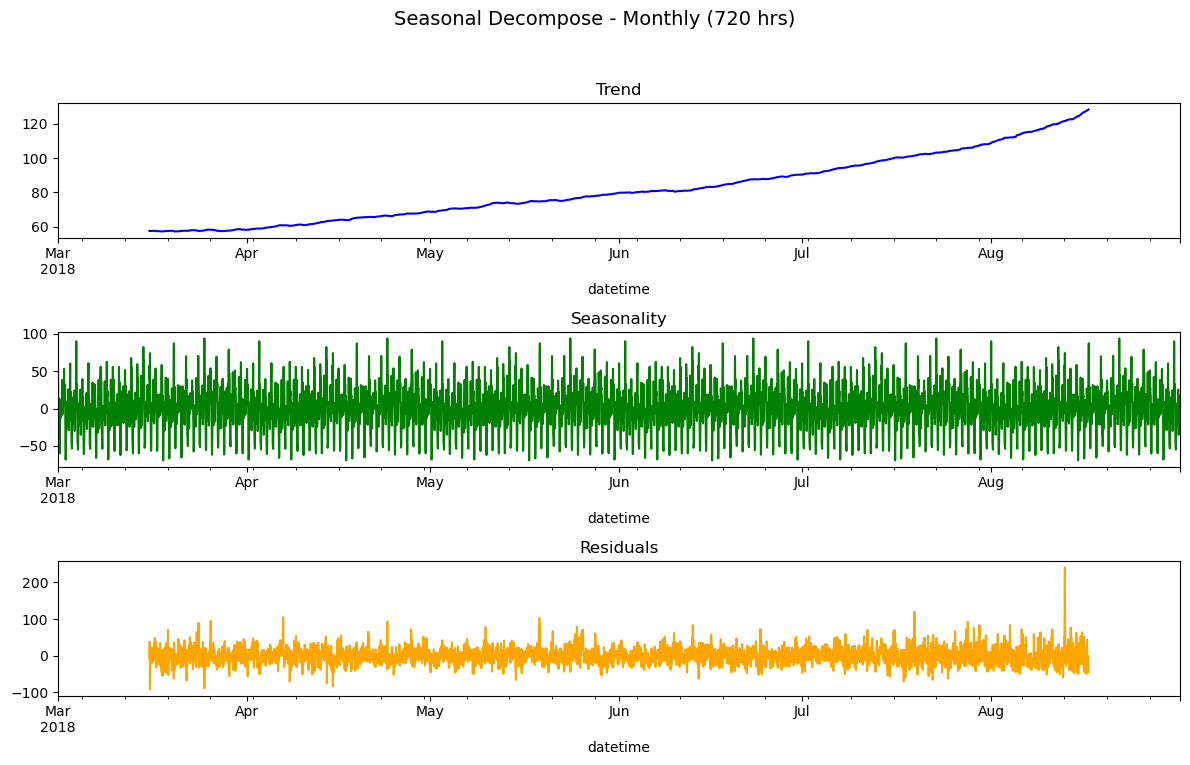

In [14]:
# 
taxi_hourly_rolling = taxi_hourly.rolling(24).mean()
plt.figure(figsize=(12,5))
taxi_hourly.plot(alpha=0.5, label='Original')
taxi_hourly_rolling.plot(label='Rolling mean (24h)')
plt.legend()
plt.show()


print(taxi_hourly.isna().sum())
taxi_hourly = taxi_hourly.fillna(0)

# Trends and seasonality
periods = {
    'Daily (24hrs)': 24,
    'Weekly (168hrs)': 24*7,
    'Monthly (720 hrs)': 24*30
}

for title, p in periods.items():
    decomposed = seasonal_decompose(taxi_hourly, model='additive', period=p)

    plt.figure(figsize=(12,8))
    plt.suptitle(f'Seasonal Decompose - {title}', fontsize=14)

    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), color='blue')
    plt.title('Trend')

    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca(), color='green')
    plt.title('Seasonality')

    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca(), color='orange')
    plt.title('Residuals')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

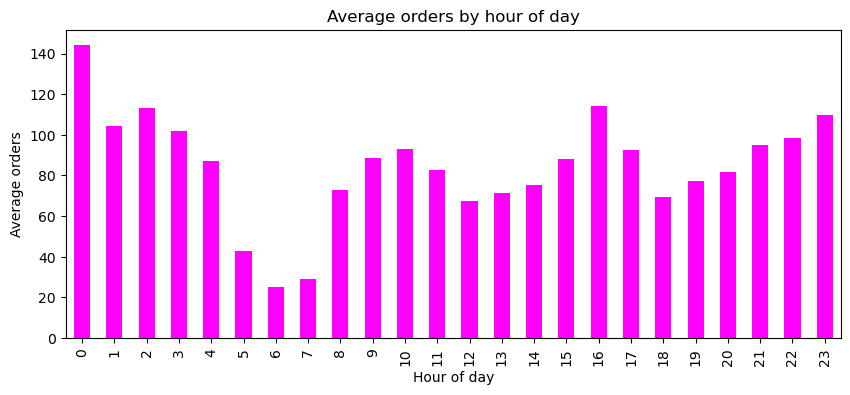

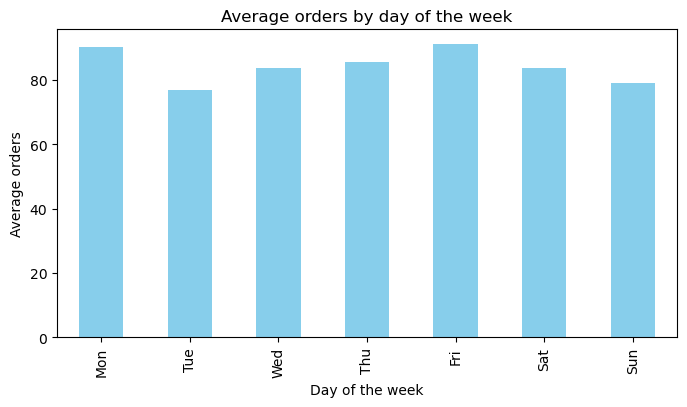

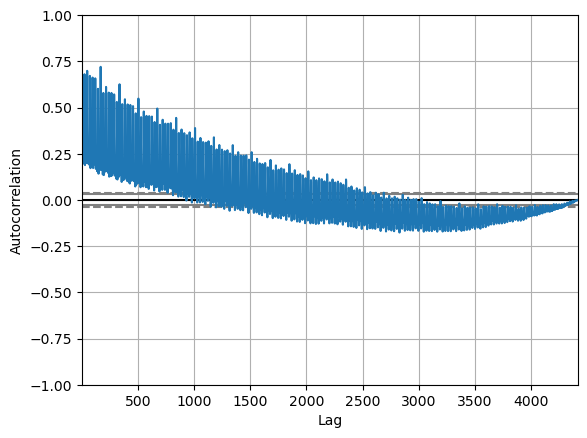

In [24]:
# Average by hour of day
hourly_mean = taxi_hourly.groupby(lambda x: x.hour).mean()

# average by day of the week (0=Monday, 1=Sunday)
weekly_mean = taxi_hourly.groupby(lambda x: x.dayofweek).mean()
weekly_mean.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Visualization
plt.figure(figsize=(10,4))
hourly_mean.plot(kind='bar', color='magenta')
plt.title('Average orders by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Average orders')

plt.figure(figsize=(8,4))
weekly_mean.plot(kind='bar', color='skyblue')
plt.title('Average orders by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average orders')

plt.show()

# Autocorrelation
autocorrelation_plot(taxi_hourly)
plt.show()


### Formacion

### Prueba